In [5]:
# Librerias #

# Loading Libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from scipy import stats
from pandas_datareader import data

import statsmodels.api as sm
#import pmdarima as pmd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

In [11]:
# Ejemplo 1: Obtener una variable a la vez
url_base  = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/api/'
cod_var   = ['PN01770AM','RD13067DM'] 
form_out  = '/json'
period    = '/2005-01/2024-05'

month_s = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']
month_d = ['01','02','03','04','05','06','07','08','09','10','11','12']

df1 = pd.DataFrame()

for j in cod_var:
    url_aux   = url_base + j + form_out + period
    resp      = requests.get(url_aux)
    resp_json = resp.json()
    periods   = resp_json['periods']
    
    value = []
    dates = []
    
    for i in periods:
        aux_dat = i['name']
        aux_val = i['values']
        dates.append(aux_dat)
        value.append(float(aux_val[0]))
    
    dict_aux = {'Fecha' : dates, 
                 resp_json['config']['series'][0]['name'] : value}
    df_aux = pd.DataFrame(dict_aux)

    df_aux['Fecha'] = df_aux['Fecha'].str.replace('.','-')
    for (s,d) in zip(month_s,month_d):
        df_aux['Fecha'] = df_aux['Fecha'].str.replace(s,d)
    df_aux['Fecha'] = pd.to_datetime(df_aux['Fecha'])

    
    df_aux.set_index(df_aux['Fecha'], inplace=True)
    df_aux = df_aux.drop(columns=['Fecha'])
    df1    = pd.concat([df1, df_aux], axis=1)

df1

df1.to_csv('data_mensual_pbi_electricidad.csv')



### Contenido

    1. Modelo VAR
    2. Introducción
    3. Definición del modelo 
    4. Orden: solo un hiperparámetro
    5. Estacionariedad
    6. Estimación de los Coeficientes VAR
    7. Un modelo multivariado frente a múltiples modelos univariados

# 1. Modelo VAR
## 2. Introducción
En este modulo, vamos a estudiar el modelo VAR, abreviatura del modelo **Vector Autoregression**. El Vector Autoregression modela el desarrollo a lo largo del tiempo de múltiples variables al mismo tiempo.

El término autorregresión debería sonar familiar por los modulos anteriores. El modelo Vector Autoregression es parte de la familia de modelos de series de tiempo. Al igual que otros modelos de esta categoría, predice el futuro en función de la evolución en el pasado de las variables objetivo.

Hay una especificidad importante en la autorregresión vectorial. A diferencia de la mayoría de los otros modelos, Vector Autoregression modela múltiples variables objetivo al mismo tiempo. Las múltiples variables se utilizan al mismo tiempo como variables objetivo y como variables explicativas entre sí. Un modelo que utiliza múltiples variables objetivo en un modelo se denomina modelo multivariante o, más específicamente, serie temporal multivariante.

## 3. Definición del modelo
Dado que el modelo VAR propone un modelo para múltiples variables objetivo, reagrupa esas variables como un vector. Una forma de estimar las relaciones entre las series de tiempo y sus valores rezagados es el proceso de autorregresión vectorial: Esto explica el nombre del modelo. La definición del modelo es la siguiente:

$$\begin{align}\begin{aligned}Y_t = \nu + A_1 Y_{t-1} + \ldots + A_p Y_{t-p} + u_t\\u_t \sim {\sf Normal}(0, \Sigma_u)\end{aligned}\end{align}$$

En esta fórmula
* $Y_t$ es un vector que contiene los valores presentes de cada una de las variables.
* El orden del modelo VAR, p, determina el número de pasos hacia atrás que se utilizan para predecir el futuro.
* v es un vector de constantes: una para cada variable objetivo.
* Existe un vector de coeficientes A para cada rezago.
* El error se denota como $u$.
* $A_i$ es una matriz de coeficiente de $K \times K$

## 4. Orden: solo un hiperparámetro
Entonces, ¿cómo funciona el número de rezagos en el modelo VAR? En los modelos anteriores, hemos visto situaciones relativamente complejas con hiperparámetros a estimar para el orden de diferentes tipos de procesos.

El modelo VAR es mucho más sencillo en este sentido. Sólo hay un orden por definir: el orden del modelo como un todo. La notación de este orden es VAR(p), en la que p es el orden.

El orden define cuántos pasos atrás en el tiempo se tienen en cuenta para explicar el presente. Un orden 1 significa que solo se tiene en cuenta el paso de tiempo anterior. Un orden 2 significa que se utilizan los dos pasos de tiempo anteriores. Y así. También puede llamar a esto el número de retrasos que se incluyen.

Si se incluye un retraso, siempre se incluye para todas las variables. No es posible con el modelo VAR usar diferentes retrasos para diferentes variables.

## 5. Estacionariedad
Otro concepto que hemos visto durante todo este recorido del curso ha sido el de estacionariedad, así que veamos cómo funciona eso en el modelo VAR.

Si recuerdas, la estacionariedad significa que una serie temporal no tiene tendencia: es estable a largo plazo. Puede utilizar la prueba Dickey Fuller aumentada para comprobar si una serie temporal es estacionaria o no.

También hemos visto la técnica llamada diferenciación, o integración, para hacer estacionaria una serie temporal no estacionaria.

Esta teoría también es muy importante para el modelo VAR. Un modelo VAR puede funcionar solo si cada una de las variables del modelo es estacionaria. Cuando se hacen modelos VAR, generalmente se trabaja con múltiples variables al mismo tiempo, por lo que puede ser un poco complicado de manejar si algunas de las series temporales son estacionarias y otras no. En ese caso, la diferenciación debe aplicarse solo a la serie temporal no estacionaria.

Hay una excepción a esta regla: el modelo de Corrección de Error Vectorial es un tipo de VAR que no requiere estacionariedad. Este modelo puede ser una buena alternativa al modelo VAR.

## 6. Estimación de los Coeficientes VAR
Los coeficientes del modelo VAR se pueden estimar mediante una técnica llamada Mínimos cuadrados multivariados. El hecho de que el modelo VAR utilice esta técnica lo hace computacionalmente relativamente eficiente. Para entender esta técnica de estimación, planteemos el modelo VAR en notación matricial:

$$Y=BZ +U $$

En este caso
* Y es una matriz que contiene los valores de y para cada variable (cada fila) y cada rezago (cada columna) para rezagos futuros.
* B es la matriz de coeficientes.
* Z es una matriz con los rezagos pasados de las y variables.
* U es una matriz con los errores del modelo.

Los mínimos cuadrados multivariados le permiten calcular los coeficientes utilizando el siguiente cálculo matricial:

$$\hat B= YZ´ (ZZ´)^{-1}$$

Los coeficientes que se estiman de esta manera son los que subyacen al modelo que verá más adelante.

## 7. Un modelo multivariado frente a múltiples modelos univariados
La autorregresión vectorial debe aplicarse a múltiples variables de destino que estén correlacionadas. Si no hay o hay muy poca correlación entre las variables, no pueden beneficiarse de combinarse en un mismo modelo.

Además de usar un modelo VAR solo en los casos en que tiene sentido combinar variables en un mismo modelo, es aún más importante usar técnicas de evaluación objetiva del modelo usando un conjunto de prueba de entrenamiento y validación cruzada. Esto puede ayudarlo a tomar la decisión correcta entre usar un modelo para múltiples variables y usar un modelo univariante separado para cada variable.

# Cargamos librerias

In [9]:
# Manipulación y tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from datetime import datetime

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Pruebas y modelación con Statsmodels
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

# No presentar advertencia
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

In [12]:
plt.style.use('classic') # fivethirtyeight  grayscale  classic
dark_style = {
    'axes.facecolor':"#abc9ea"}  # '#484366'  '#008080' "#abc9ea","#98daa7","#f3aba8","#d3c3f7","#f3f3af" 
plt.rcParams.update(dark_style)

## Cargamos los datos

In [68]:
mdata = pd.read_csv("data_mensual_pbi_electricidad.csv") 
mdata

,Fecha,Producto bruto interno y demanda interna (índice 2007=100) - PBI,Producción de electricidad por departamento - Total (gwh)
0,2005-01-01,79.979161,2101.542732
1,2005-02-01,80.134460,1949.377128
2,2005-03-01,81.396413,2153.859359
3,2005-04-01,87.073447,2109.382880
4,2005-05-01,92.141455,2177.966859
...,...,...,...
226,2023-11-01,181.157269,5123.241253
227,2023-12-01,196.103913,5349.401157
228,2024-01-01,166.462481,5386.140003
229,2024-02-01,166.994905,5208.008887


In [69]:
# mdata = pd.read_csv("data_mensual_pbi_electricidad.csv", parse_dates= ["Month"], index_col=0) 
mdata = mdata.rename(columns={"Producto bruto interno y demanda interna (índice 2007=100) - PBI": "pbi"})
mdata = mdata.rename(columns={"Producción de electricidad por departamento - Total (gwh)": "electr"})

mdata['Fecha'] = mdata['Fecha'].astype(str).str[:7]


mdata.head()


,Fecha,pbi,electr
0,2005-01,79.979161,2101.542732
1,2005-02,80.134460,1949.377128
2,2005-03,81.396413,2153.859359
3,2005-04,87.073447,2109.382880
4,2005-05,92.141455,2177.966859


In [26]:
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fecha   231 non-null    object 
 1   pbi     231 non-null    float64
 2   elect   231 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.5+ KB


Text(0, 0.5, 'valor')

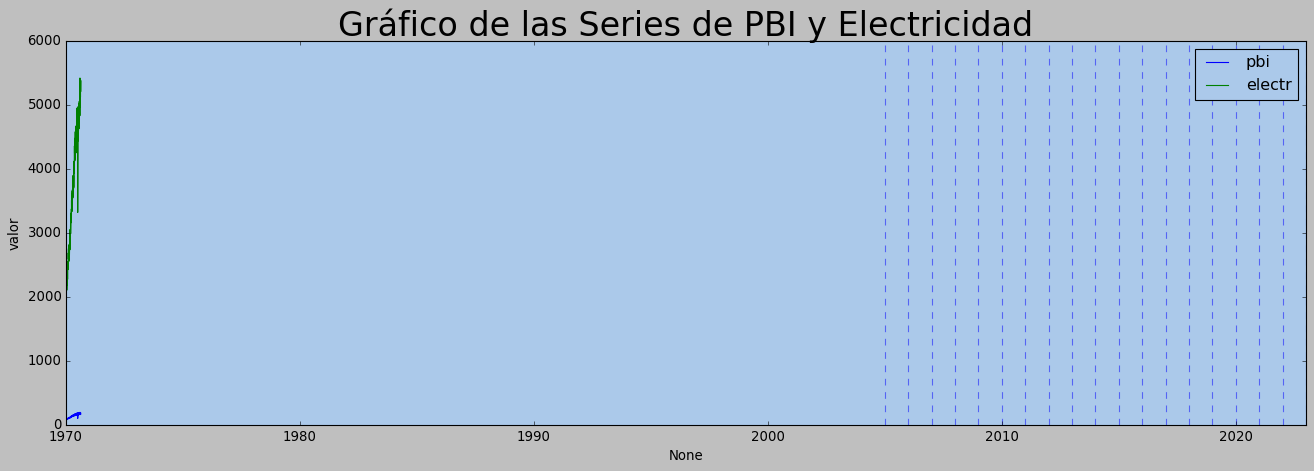

In [70]:
plt.figure(figsize=(20,6))
plt.rcParams["figure.figsize"] = (20, 8)

sns.lineplot(mdata, x = mdata.index, y = mdata["pbi"], label = "pbi")
sns.lineplot(mdata, x = mdata.index, y = mdata["electr"], label = "electr")

for year in range(2005, 2024):
    plt.axvline(datetime(year,1,1), linestyle='--', color='b', alpha=0.5)

#plt.legend(['PBI', 'ELECTRICIDAD'], fontsize=16);
plt.title("Gráfico de las Series de PBI y Electricidad", size=30);

plt.ylabel("valor")

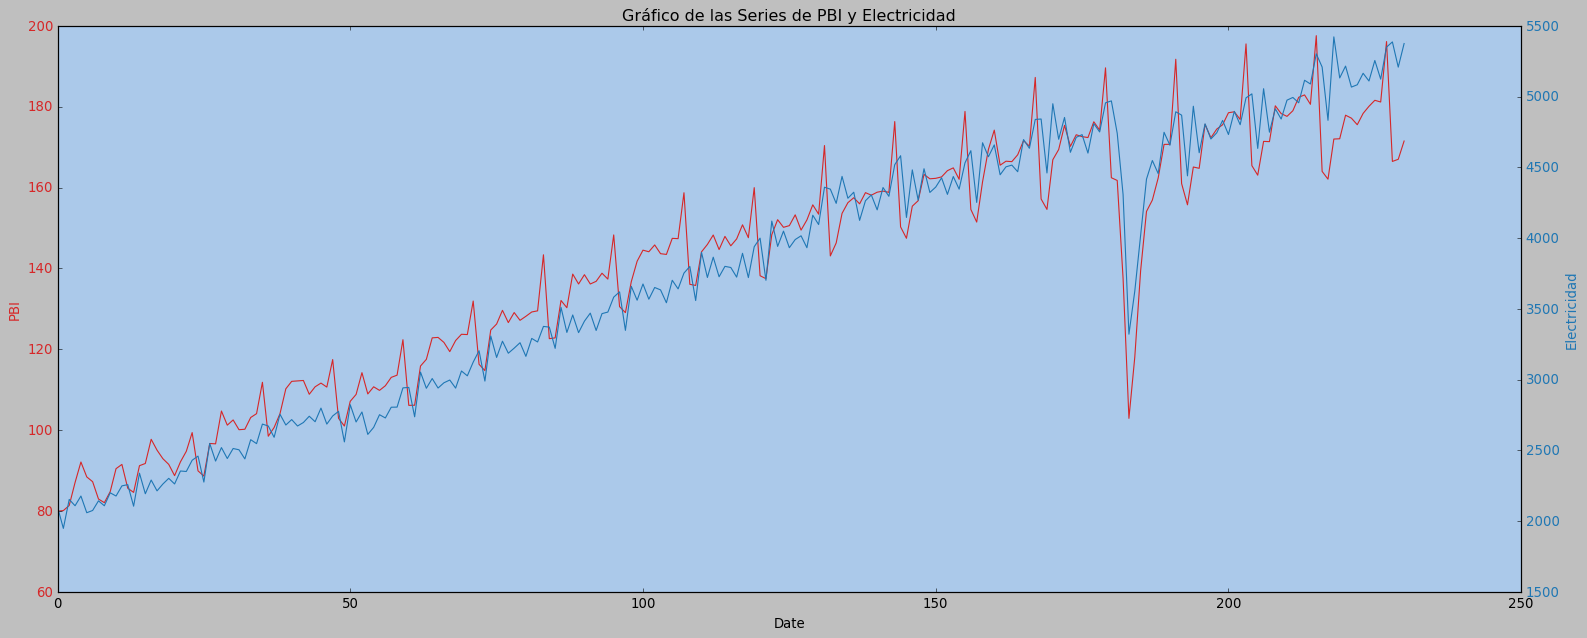

In [71]:
fig, ax1 = plt.subplots(figsize=(20, 8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('PBI', color=color)
ax1.plot(mdata.index, mdata['pbi'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Electricidad', color=color)  # we already handled the x-label with ax1
ax2.plot(mdata.index, mdata['electr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Gráfico de las Series de PBI y Electricidad')
plt.show()


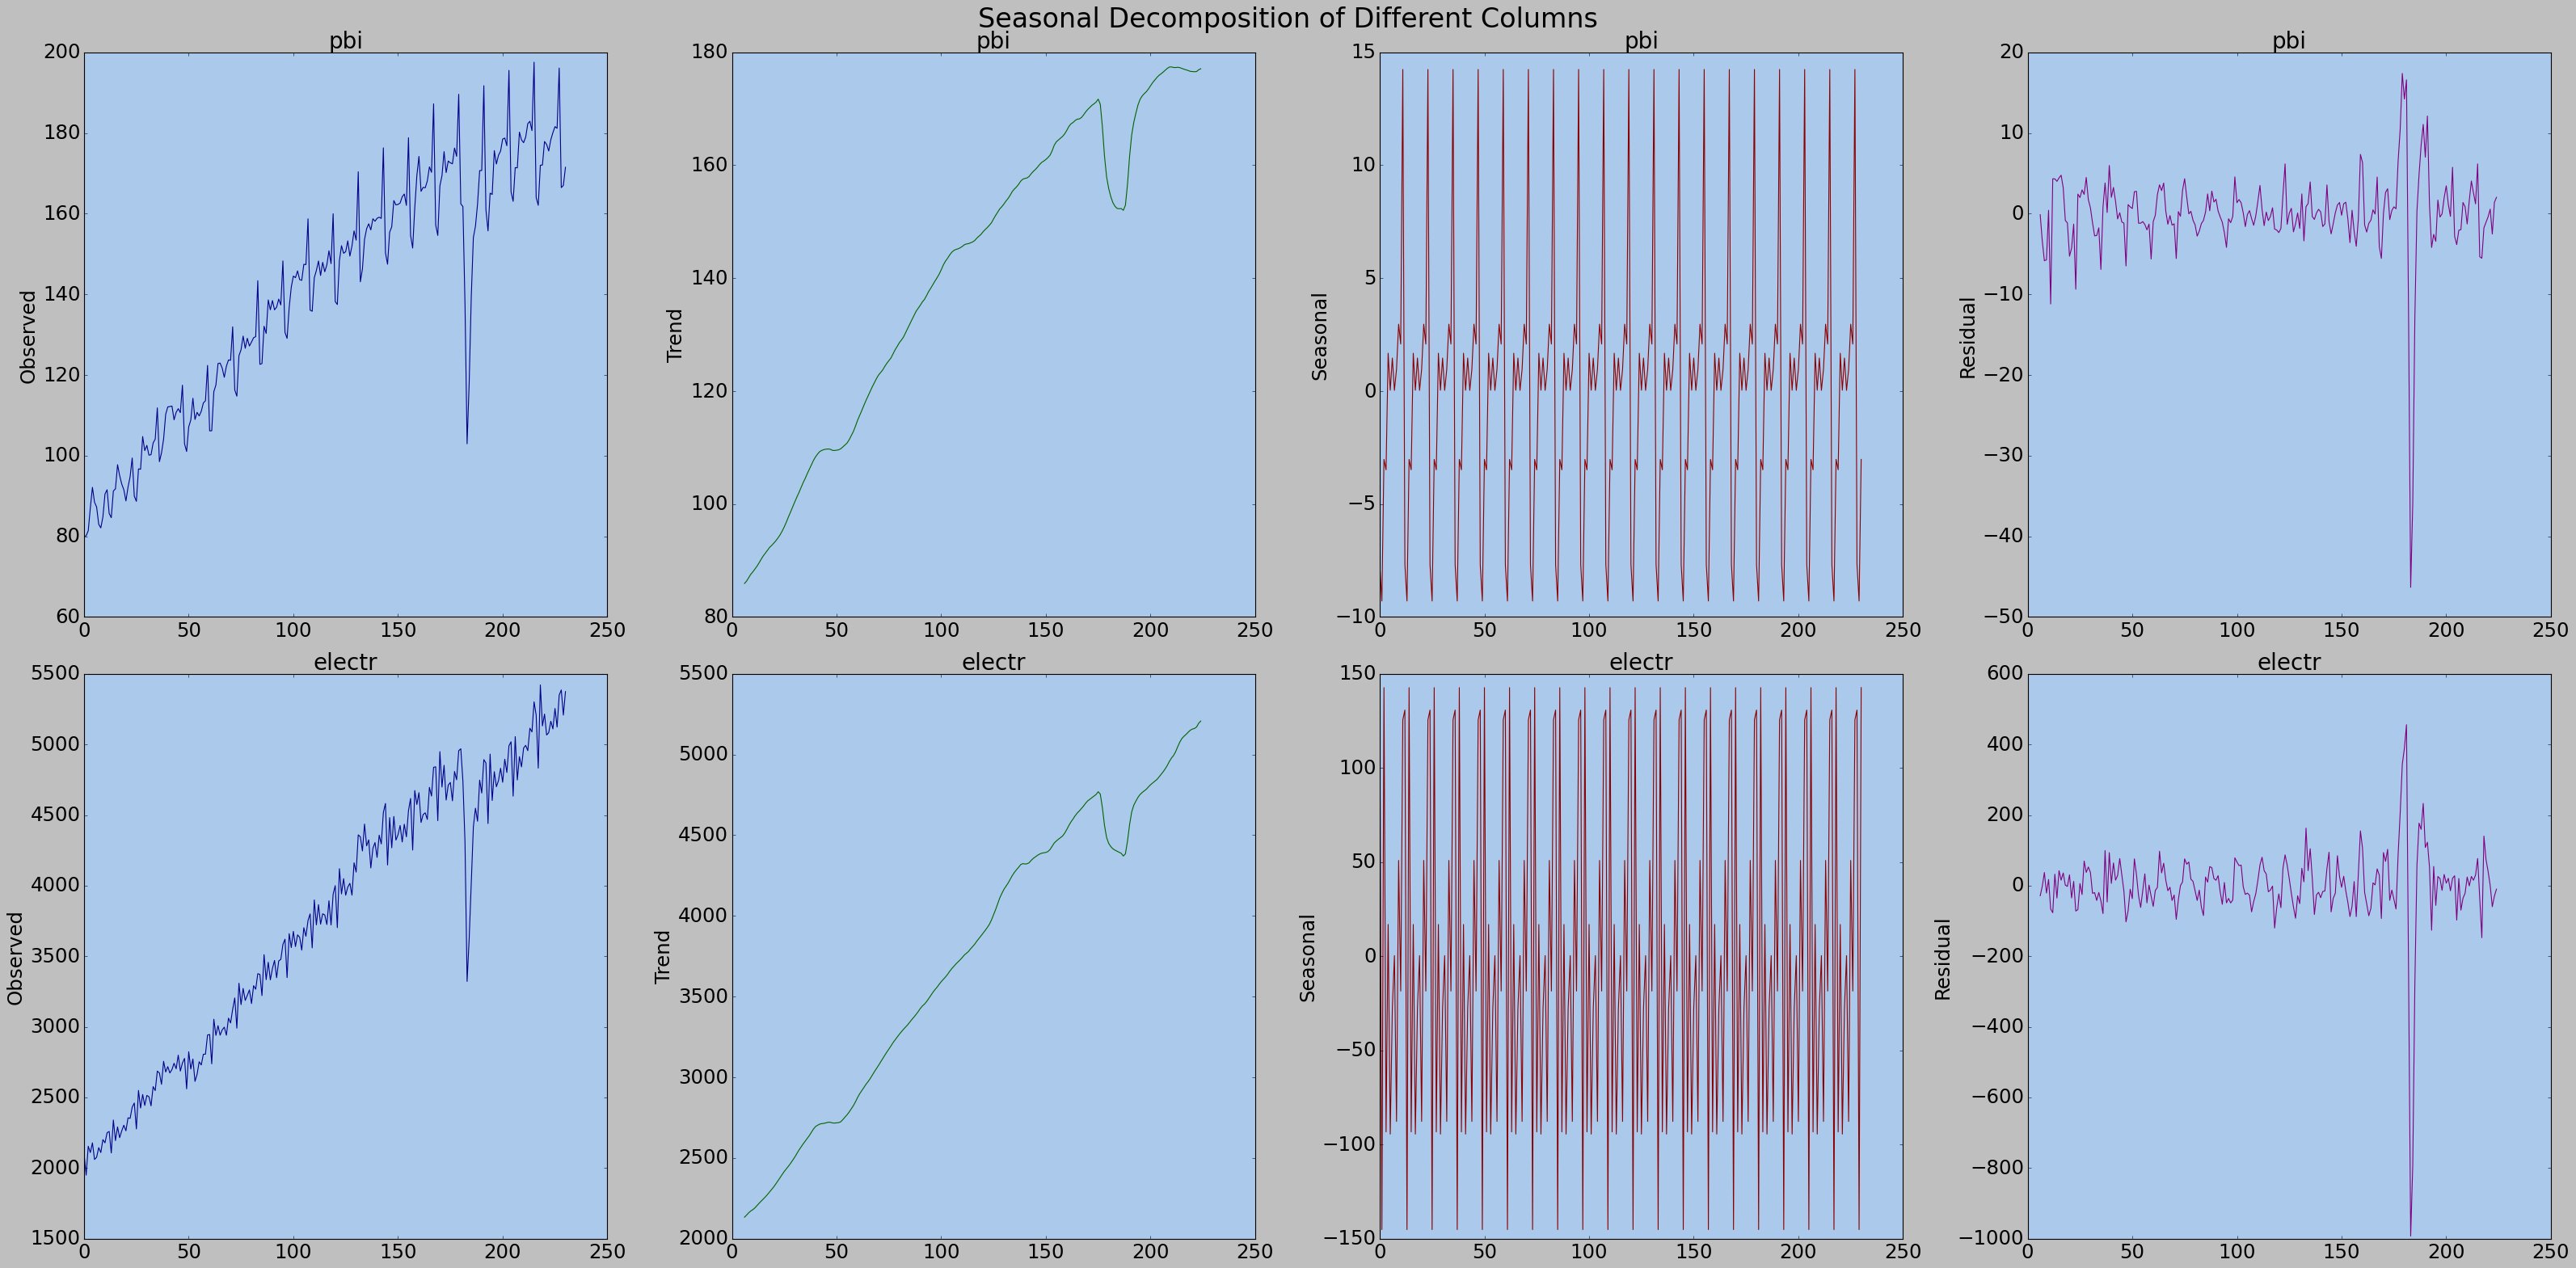

In [72]:

# Define darker colors using RGB values
colors = [(0, 0, 139), (0, 100, 0), (139, 0, 0), (128, 0, 128)]  # Dark blue, Dark green, Dark red, Dark purple

# Normalize RGB values to range [0, 1]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# Perform seasonal decomposition for each column
columns = ['pbi', 'electr']
fig, axes = plt.subplots(len(columns), 4, figsize=(40, 20))

for i, col in enumerate(columns):
    decompose = seasonal_decompose(mdata[col], model='additive', period=12)
    
    decompose.observed.plot(ax=axes[i, 0], color=colors[0], fontsize=22)
    axes[i, 0].set_ylabel('Observed', fontsize=22)
    axes[i, 0].set_title(col, fontsize=25)
    
    decompose.trend.plot(ax=axes[i, 1], color=colors[1], fontsize=22)
    axes[i, 1].set_ylabel('Trend', fontsize=22)
    axes[i, 1].set_title(col, fontsize=25)
    
    decompose.seasonal.plot(ax=axes[i, 2], color=colors[2], fontsize=22)
    axes[i, 2].set_ylabel('Seasonal', fontsize=22)
    axes[i, 2].set_title(col, fontsize=25)
    
    decompose.resid.plot(ax=axes[i, 3], color=colors[3], fontsize=22)
    axes[i, 3].set_ylabel('Residual', fontsize=22)
    axes[i, 3].set_title(col, fontsize=25)

# Add main title
fig.suptitle('Seasonal Decomposition of Different Columns', fontsize=30)

plt.tight_layout()
plt.show()

## Revisando la Estacionariedad

### Prueba Dickey Fuller

Uno de los supuestos clave del modelo VAR es que todas las variables incluidas en el modelo deben ser estacionarias. La estacionariedad implica que la media y la varianza de la serie de tiempo son constantes a lo largo del tiempo. Si alguna de las variables no es estacionaria, se debe realizar una transformación adecuada, como la diferenciación, para lograr la estacionariedad antes de aplicar el modelo VAR.

Aquí está la función de prueba ADF para verificar datos estacionarios:

In [73]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print(" Rechazar la hipótesis nula")
        print(" Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print(" Los datos no son estacionarios")

In [74]:
for name, column in mdata[["pbi","electr"]].items():
    Augmented_Dickey_Fuller_Test_func(mdata[name],name)
    print('\n')

Resultados de la prueba de Dickey-Fuller para columna: pbi
Test Statistic                  -1.534923
p-value                          0.516170
No Lags Used                    14.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
 Los datos no son estacionarios


Resultados de la prueba de Dickey-Fuller para columna: electr
Test Statistic                  -0.866734
p-value                          0.798730
No Lags Used                    14.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
 Los datos no son estacionarios




Como podemos ver ambas series no son estacionarias, ambos **p-values** son mayores al 5%, por lo tanto, procederemos a diferenciarlas

## Removiendo tendencia

Para esto vamos a diferencias nuestro datos

In [96]:
mdata = mdata[["Fecha","pbi","electr"]]
data = mdata.diff().dropna()
data

TypeError: unsupported operand type(s) for -: 'str' and 'str'

Verifiquemos nuevamente si la series después del primer diferenciado son estacionarias

In [76]:
for name, column in data[["pbi","electr"]].items():
    Augmented_Dickey_Fuller_Test_func(data[name],name)
    print('\n')

Resultados de la prueba de Dickey-Fuller para columna: pbi
Test Statistic                  -4.800375
p-value                          0.000054
No Lags Used                    13.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64
Conclusion:====>
 Rechazar la hipótesis nula
 Los datos son estacionarios


Resultados de la prueba de Dickey-Fuller para columna: electr
Test Statistic                  -5.284636
p-value                          0.000006
No Lags Used                    13.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64
Conclusion:====>
 Rechazar la hipótesis nula
 Los datos son estacionarios




Al aplicar la prueba de `Dickey-Fuller` las series ahora son estacionarias. 

Visualicemos ahora la series.

In [77]:
mdata


,pbi,electr,Fecha
0,79.979161,2101.542732,2005-01
1,80.134460,1949.377128,2005-02
2,81.396413,2153.859359,2005-03
3,87.073447,2109.382880,2005-04
4,92.141455,2177.966859,2005-05
...,...,...,...
226,181.157269,5123.241253,2023-11
227,196.103913,5349.401157,2023-12
228,166.462481,5386.140003,2024-01
229,166.994905,5208.008887,2024-02


ConversionError: Failed to convert value(s) to axis units: datetime.datetime(2005, 1, 1, 0, 0)

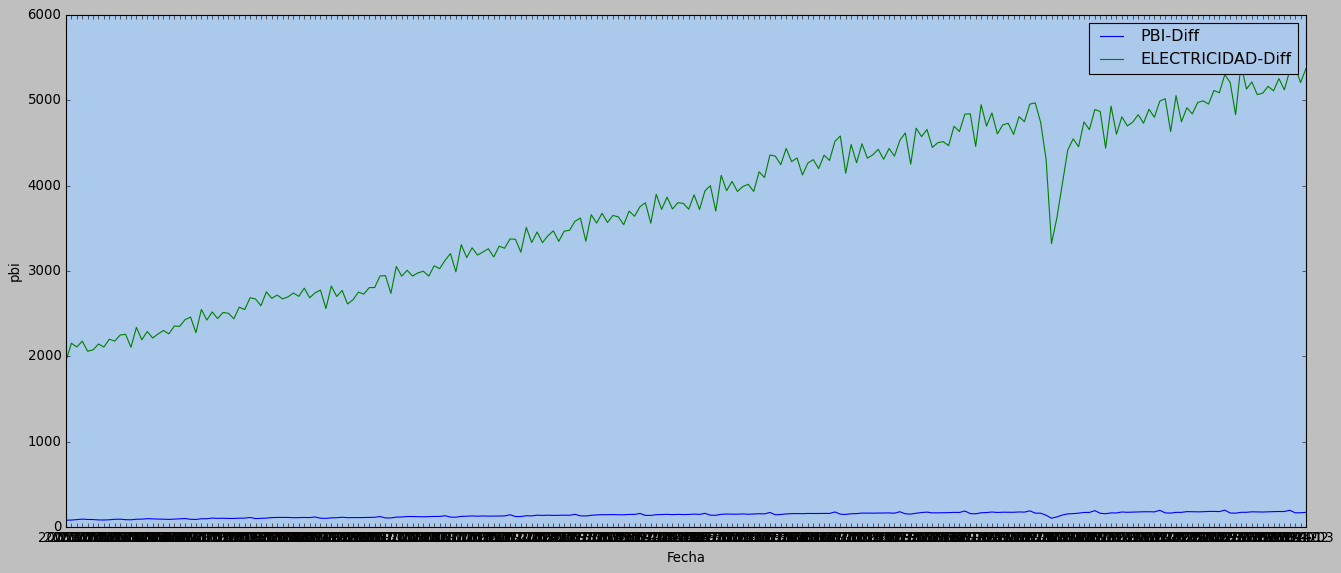

In [78]:
# Assuming 'mdata' is your DataFrame and it's indexed by date
mdata_filtered = mdata.iloc[1:]  # Exclude the first row

# Example assumes mdata has been appropriately transformed or filtered
sns.lineplot(data=mdata_filtered, x='Fecha', y='pbi', label="PBI-Diff")
sns.lineplot(data=mdata_filtered, x='Fecha', y='electr', label="ELECTRICIDAD-Diff")

plt.axhline(0, linestyle='--', color='k', alpha=0.3)  # Zero-line for reference
for year in range(2005, 2021, 5):
    plt.axvline(datetime(year,1,1), linestyle='--', color='b', alpha=0.5)

plt.ylabel("Difference")
plt.title("Adjusted Data Series for PBI and Electricidad")
plt.legend()
plt.show()


In [79]:
def tsplot(y, lags=None, figsize=(18, 7), style='bmh'): # [3]
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Gráfico de analisys de Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()

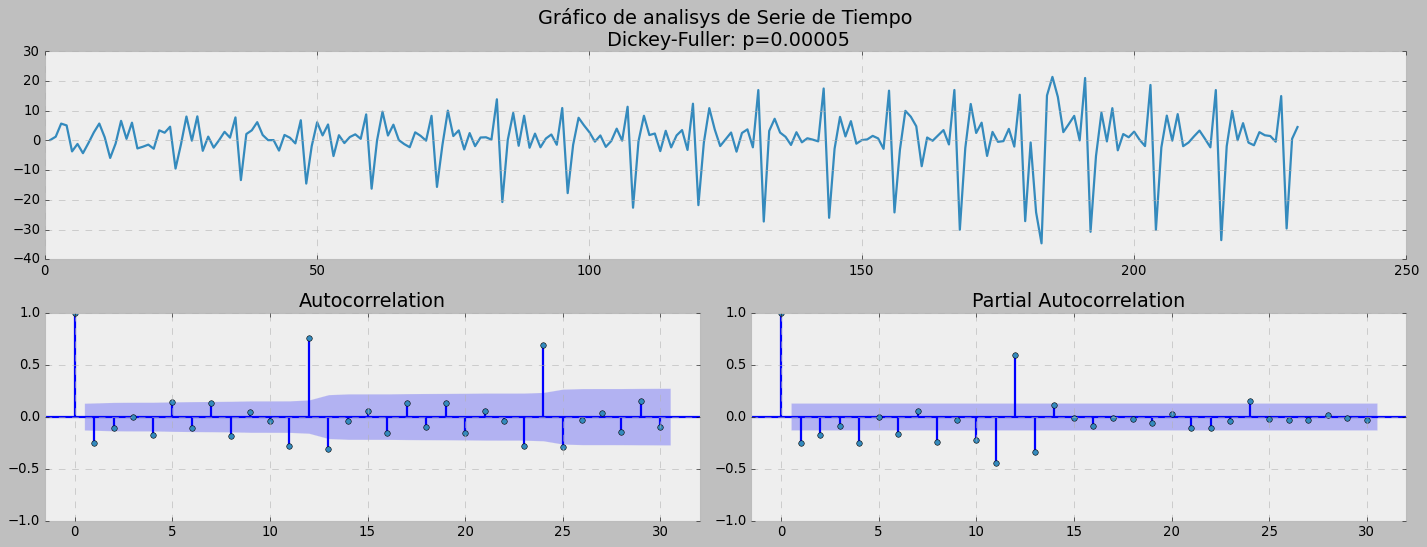

In [80]:
tsplot(data["pbi"], lags=30)

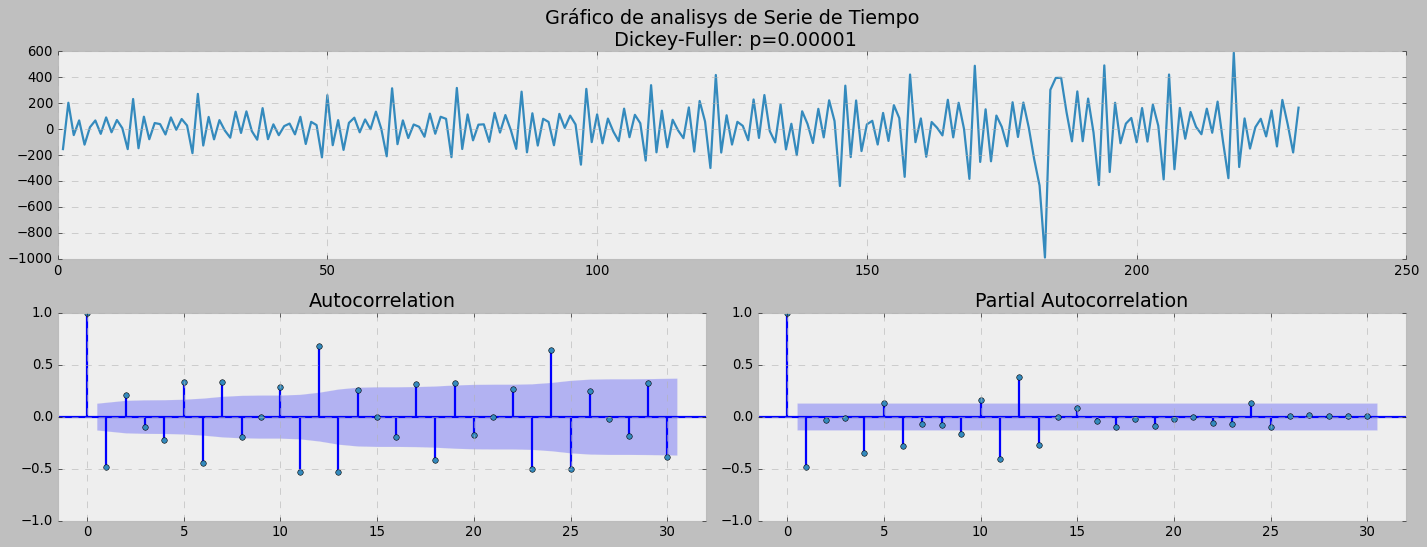

In [81]:
tsplot(data["electr"], lags=30);

## **División de los Datos** 


Dividamos nuestros datos en conjuntos.
1. Datos para entrenar nuestro modelo `VAR`.
2. Datos para probar nuestro modelo.

Para los datos de prueba usaremos las últimas 24 meses para probar y evaluar el rendimiento de nuestro modelo.

In [82]:
train = data[:-24]
test = data[-24:]# Tomaremos los últimos 12 meses

In [83]:
train

,pbi,electr
1,0.155299,-152.165604
2,1.261953,204.482231
3,5.677034,-44.476479
4,5.068008,68.583979
5,-3.685682,-117.914391
...,...,...
202,-1.899446,-94.325483
203,18.685295,189.740657
204,-30.100548,28.175003
205,-2.360561,-385.384892


In [84]:
test

,pbi,electr
207,-0.063853,-307.089827
208,8.861674,165.085791
209,-1.926022,-72.291838
210,-0.686162,133.459432
211,1.388641,19.105607
212,3.329193,-37.778770
213,0.583280,159.122411
214,-2.318513,-26.250068
215,16.971817,213.133259
216,-33.563188,-93.646079


## Implementación del Modelo

Nuestro primer paso es determinar el número requerido de `Autoregressivo`, vamos a buscarlo de 2 formas:

- ### Forma 1:

In [85]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13]:# orden del modelo VAR
    #model = VAR(train[["ice_cream1_scaler_diff","heater1_scaler_diff"]])
    model = VAR(train)
    results = model.fit(i, ic = 'aic')
    print(f'Orden : {i}, AIC:  {results.aic}, BIC: { results.bic}')

Orden : 1, AIC:  13.560072966317007, BIC: 13.657331794974716
Orden : 2, AIC:  13.442148924426576, BIC: 13.604801865301292
Orden : 3, AIC:  13.216872364478961, BIC: 13.44536932855081
Orden : 4, AIC:  13.200081467580025, BIC: 13.494877599031618
Orden : 5, AIC:  13.074356616328659, BIC: 13.435912377409752
Orden : 6, AIC:  12.896266251397964, BIC: 13.32504750904921
Orden : 7, AIC:  12.885519905271687, BIC: 13.381998019551762
Orden : 8, AIC:  12.74054049308435, BIC: 13.305192407446036
Orden : 9, AIC:  12.619310249246302, BIC: 13.252618582708452
Orden : 10, AIC:  12.040415607635357, BIC: 12.742868748899038
Orden : 11, AIC:  11.470104551899555, BIC: 12.242196755458181
Orden : 12, AIC:  11.06790634272436, BIC: 11.910137827019032
Orden : 13, AIC:  10.96746624253825, BIC: 11.880343290211119


- ### Forma 2:

In [86]:
#model = VAR(train[["ice_cream1_scaler_diff","heater1_scaler_diff"]])
model = VAR(train)
res = model.select_order() # maxlags=13
res.summary()

,AIC,BIC,FPE,HQIC
0,14.69,14.72,2.388e+06,14.70
1,13.64,13.74,8.410e+05,13.68
2,13.52,13.69,7.429e+05,13.59
3,13.28,13.52,5.859e+05,13.38
4,13.27,13.57,5.782e+05,13.39
5,13.13,13.51,5.058e+05,13.28
6,12.94,13.38,4.183e+05,13.12
7,12.93,13.44,4.115e+05,13.13
8,12.76,13.34,3.482e+05,12.99
9,12.62,13.26,3.023e+05,12.88


In [87]:
res.selected_orders

{'aic': 13, 'bic': 13, 'hqic': 13, 'fpe': 13}

El AR(12) autorregresivo parece proporcionar el Criterio de información de Akaike (AIC) y el Criterio de información bayesiano (BIC) mínimos, así que ajustemos y pronostiquemos.

AIC y BIC son dos formas de puntuar un modelo en función de su probabilidad logarítmica y complejidad.

In [88]:
# Entreno el modelo
results = model.fit(maxlags = 12,ic = 'aic', method='ols')
display(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 17, Jun, 2024
Time:                     19:46:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.9101
Nobs:                     194.000    HQIC:                   11.4089
Log likelihood:          -1574.14    FPE:                    64266.2
AIC:                      11.0679    Det(Omega_mle):         50431.0
--------------------------------------------------------------------
Results for equation pbi
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.548248         0.462792            1.185           0.236
L1.pbi             0.058984         0.124182            0.475           0.635
L1.electr          0.010279         0.006139            1.674           0.

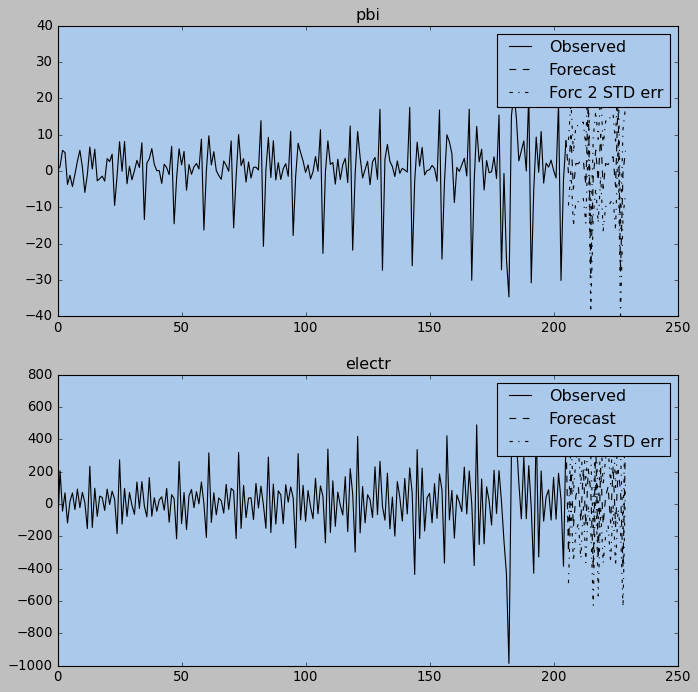

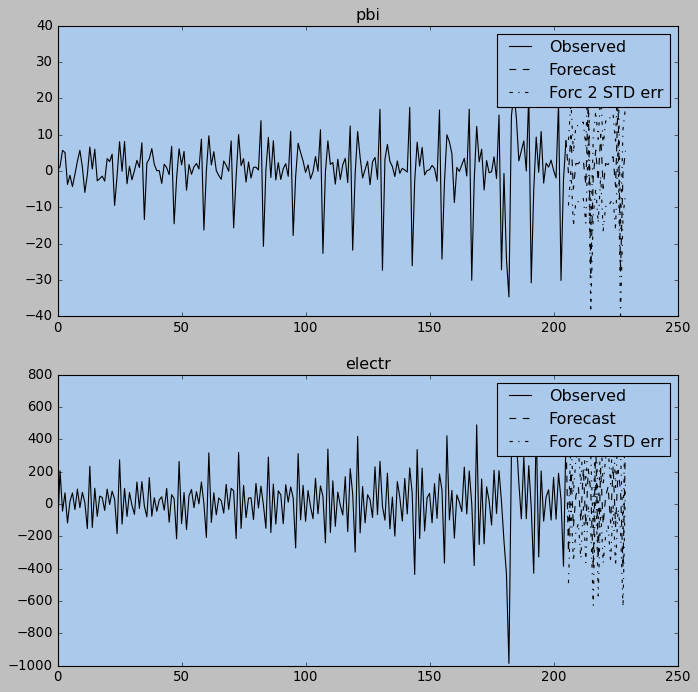

In [89]:
results.plot_forecast(24)

In [90]:
lag_order = results.k_ar
lag_order

12

In [91]:
test.shape

(24, 2)

## Forecasting

El predictor lineal es el pronóstico óptimo de h-paso adelante en términos de error cuadrático medio:

$$y_t(h) = \nu + A_1 y_t(h − 1) + \cdots + A_p y_t(h − p)$$

Podemos utilizar la función de pronóstico para producir este pronóstico. Tenga en cuenta que tenemos que especificar el "valor inicial" para el pronóstico:

In [92]:
y_hat = pd.DataFrame(results.forecast(y=test.values[-lag_order:], steps = 24), columns = ["pbi", "electr"])
y_hat

,pbi,electr
0,-3.191043,-290.280792
1,6.176166,84.679865
2,2.617948,-51.179166
3,2.208259,118.312905
4,0.486106,34.456753
5,3.642416,-42.795610
6,2.407355,173.483302
7,3.694900,-48.628478
8,14.342133,231.787901
9,-30.175711,-9.831399


Recordemos que Para hacer que los datos sean estacionarios, usamos la diferenciación de Pandas después de pronosticar los resultados. Necesitamos invertir el resultado a la escala original. Como no tenemos una función de Pandas para esto, definamos una función personalizada para invertir la diferenciación de Pandas.


Vamos a hacer el proceso inverso para el resultado de nuestro forecasting

In [93]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [94]:
df_results = invert_transformation(mdata[-24:], y_hat, second_diff=False)  
df_results

KeyError: 'Fecha'

Vamos a guardar el resultado forecasting junto con los datos historicos

In [95]:
mdata[-24:]

,pbi,electr,Fecha
207,171.356954,4748.498552,2022-04
208,180.218628,4913.584343,2022-05
209,178.292607,4841.292505,2022-06
210,177.606445,4974.751936,2022-07
211,178.995086,4993.857543,2022-08
212,182.324279,4956.078773,2022-09
213,182.907558,5115.201184,2022-10
214,180.589045,5088.951115,2022-11
215,197.560862,5302.084375,2022-12
216,163.997674,5208.438296,2023-01


In [30]:
prueba = mdata[-24:]
prueba["heater_forecast"] = df_results["heater_forecast"].values
prueba["ice_cream_forecast"] = df_results["ice_cream_forecast"].values
prueba

,heater,ice_cream,heater_forecast,ice_cream_forecast
Month,,,,
2018-07-01,21,91,19.845797,69.125084
2018-08-01,21,66,23.639987,53.721578
2018-09-01,24,49,30.210295,44.678651
2018-10-01,39,39,45.567674,40.619945
2018-11-01,53,34,55.377911,38.275140
2018-12-01,48,36,50.832685,42.764971
2019-01-01,49,39,43.517327,43.322392
2019-02-01,39,42,33.757728,43.707137
2019-03-01,30,53,27.375947,48.241248


In [ ]:
mdata

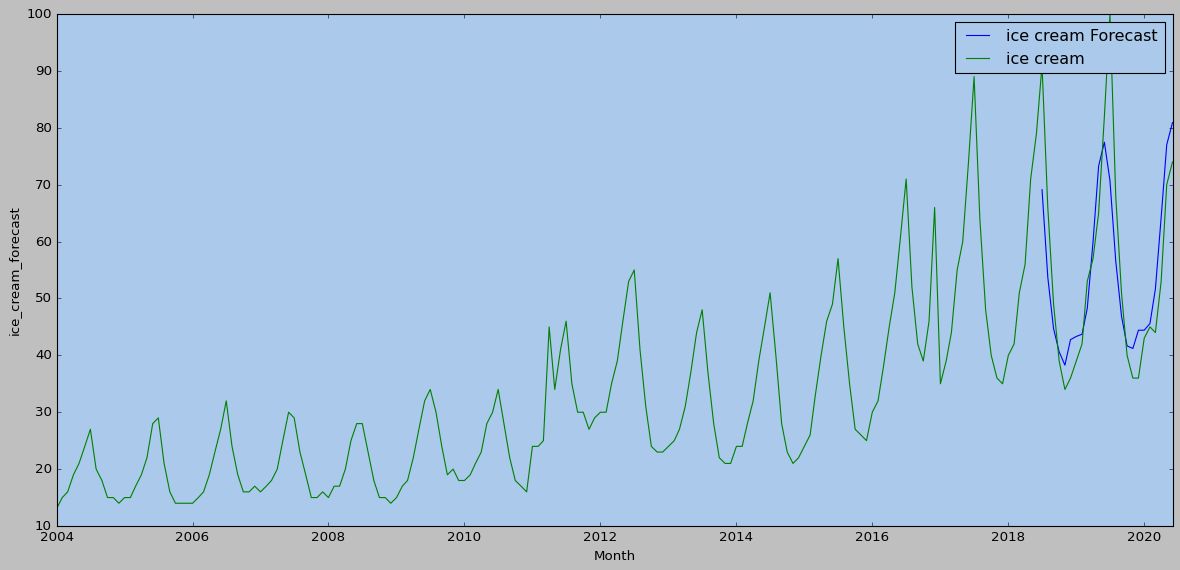

In [31]:
#plt.figure(figsize=(20,6))
plt.rcParams["figure.figsize"] = (18, 8)

sns.lineplot(prueba, x = prueba.index, y = prueba["ice_cream_forecast"], label = "ice cream Forecast");
sns.lineplot(mdata, x = mdata.index, y = mdata["ice_cream"], label = "ice cream");
#sns.lineplot(prueba, x = prueba.index, y = prueba["heater_forecast"], label = "heater_forecast");
plt.show()

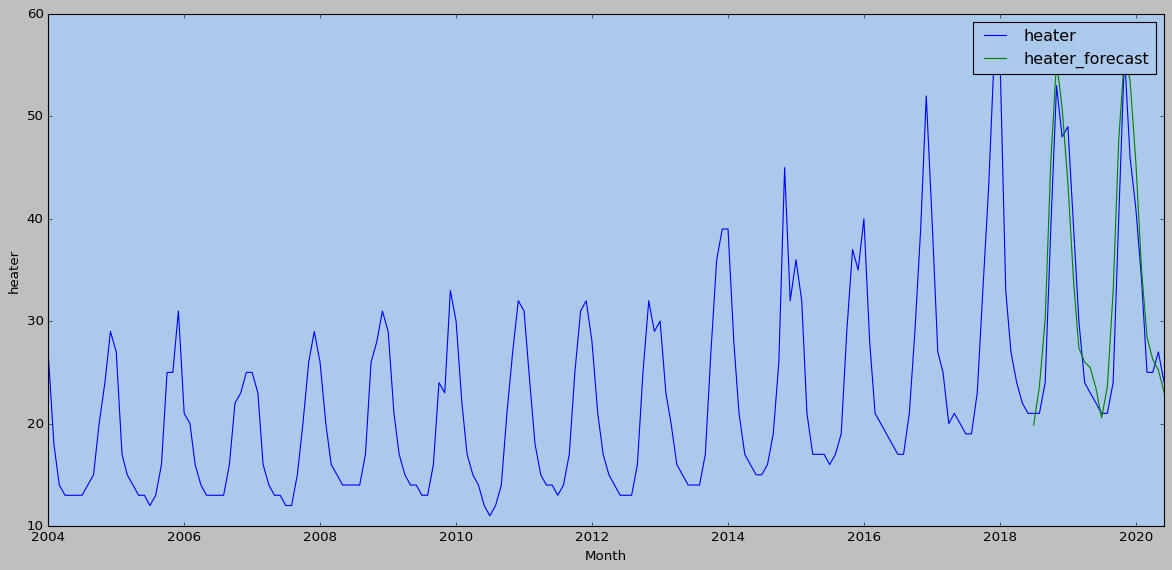

In [32]:
#plt.figure(figsize=(20,6))
plt.rcParams["figure.figsize"] = (18, 8)

sns.lineplot(mdata, x = mdata.index, y = mdata["heater"], label = "heater");
sns.lineplot(prueba, x = prueba.index, y = prueba["heater_forecast"], label = "heater_forecast");
plt.show()

## Análisis de respuesta de impulso¶

Las respuestas al impulso son de interés en los estudios econométricos: son las respuestas estimadas a un impulso unitario en una de las variables. En la práctica, se calculan utilizando la representación MA() del proceso VAR(p):

$$Y_t = \mu + \sum_{i=0}^\infty \Phi_i u_{t-i}$$

Podemos realizar un análisis de respuesta al impulso llamando a la función irf en un objeto VARResults:

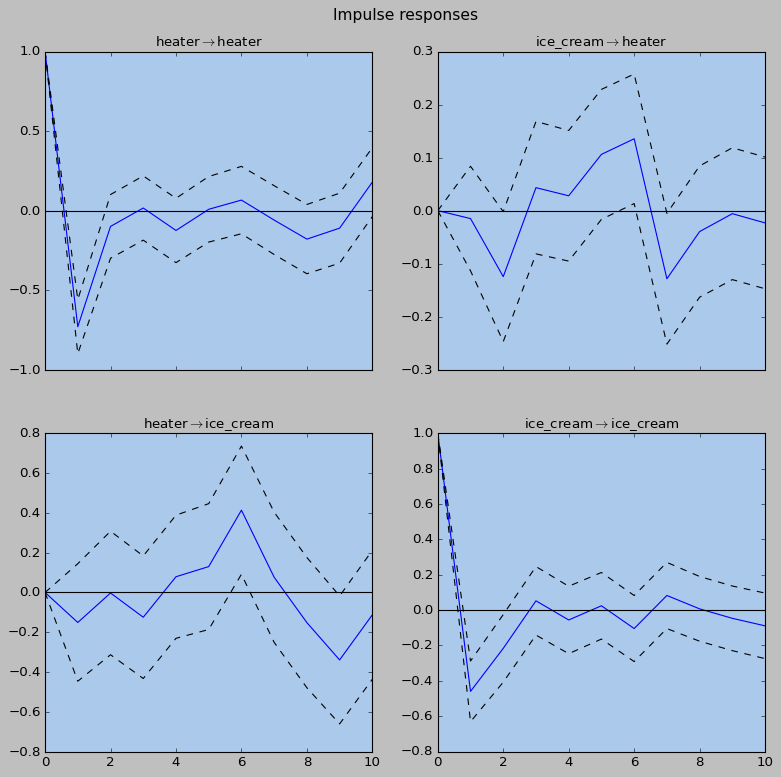

In [33]:
# Plot the impulse response functions
irf = results.irf(10)
irf.plot()
plt.show()

### Interpretación para el Análisis Impulso Respuesta:

La función de respuesta al impulso (IRF) muestra la reacción del pronóstico de cada variable ante un shock de una desviación estándar en uno de los términos de error.
La razón detrás del uso de un cambio de una desviación estándar es proporcionar una forma estandarizada y consistente de medir el impacto de los shocks. El impacto se normaliza a la escala de la variable, teniendo en cuenta el hecho de que las variables pueden tener diferentes escalas y volatilidades.

Arriba a la izquierda: la respuesta de la Variable1 a un shock en la Variable1

Por ejemplo, podemos ver que un shock de 1 desviación estándar en la Variable1 (arriba a la izquierda) significa que generalmente volverá lentamente a su valor original durante los próximos 10 períodos.
La razón por la que la línea comienza en 1 en este ejemplo es porque se supone que un shock es un cambio de 1 desviación estándar en la variable que se está impactando, por lo que si se hace contra sí misma, por supuesto, comenzará en 1 ya que el shock fue un cambio de 1 desviación estándar. a sí mismo. Esta es también la razón por la que los gráficos del medio y de la parte inferior derecha comienzan en 1.
Las líneas discontinuas representan los intervalos de confianza, que se calculan utilizando los errores estándar de los coeficientes.

Los efectos acumulativos $ \Psi_n = \sum_{i=0}^n \Phi_i$
 Se puede trazar con los efectos de largo plazo de la siguiente manera:

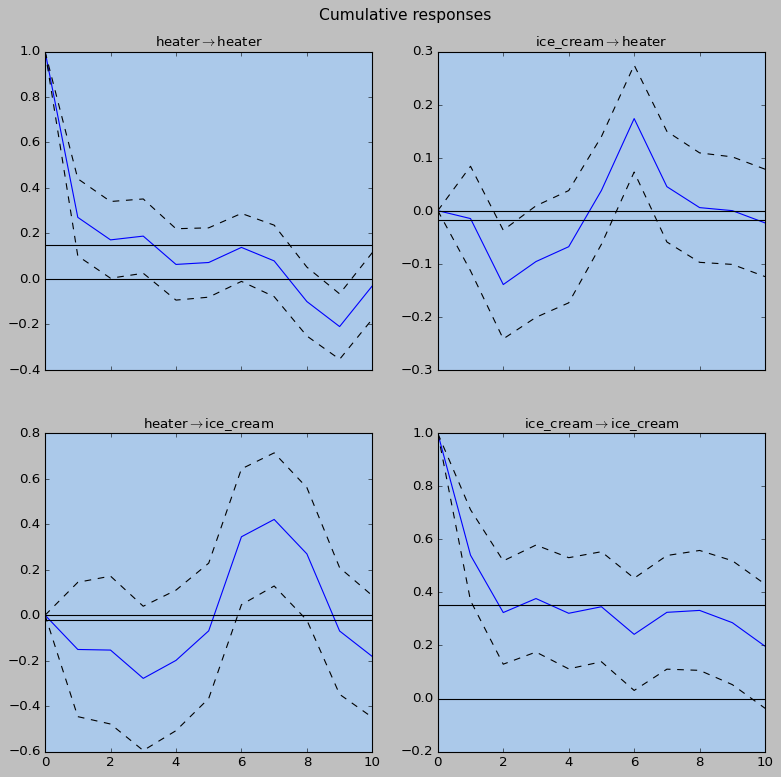

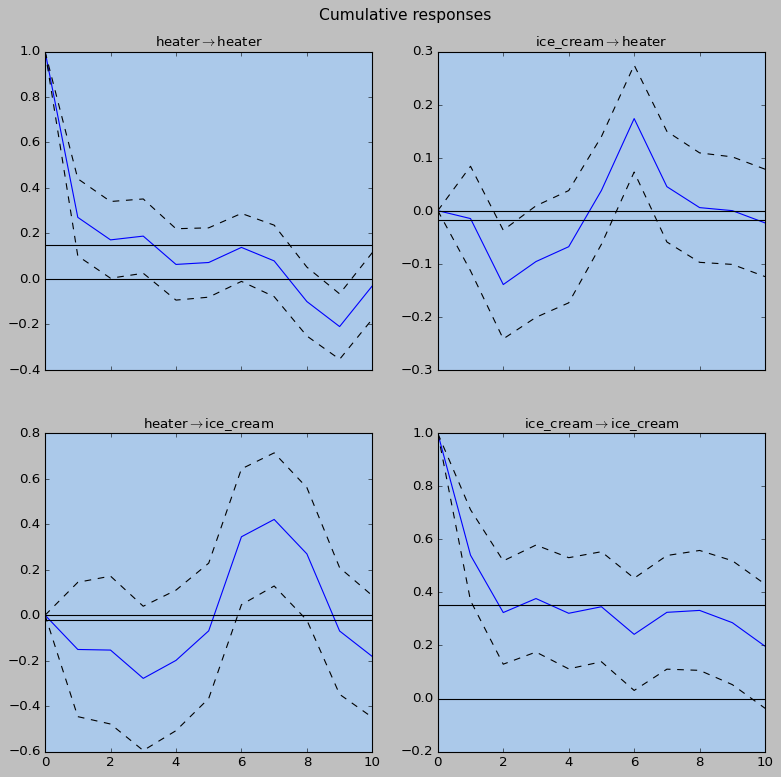

In [34]:
irf.plot_cum_effects(orth=False)

## DESCOMPOSICIÓN DE LA VARIANZA DEL ERROR DE PRONÓSTICO (FEVD)¶
La varianza del error de pronóstico, en el contexto de un modelo de vector autorregresión (VAR), se refiere a la variabilidad de los errores de pronóstico al predecir valores futuros de una variable utilizando el modelo VAR. Es una medida de la incertidumbre asociada a los pronósticos generados por el modelo.

Los errores de pronóstico del componente j en k en un pronóstico i-paso adelante se pueden descomponer utilizando las respuestas de impulso ortogonalizadas $\Theta_i$:

$$\begin{align}\begin{aligned}\omega_{jk, i} = \sum_{i=0}^{h-1} (e_j^\prime \Theta_i e_k)^2 / \mathrm{MSE}_j(h)\\\mathrm{MSE}_j(h) = \sum_{i=0}^{h-1} e_j^\prime \Phi_i \Sigma_u \Phi_i^\prime e_j\end{aligned}\end{align}$$

Cuando crea un pronóstico utilizando un modelo VAR, básicamente está utilizando valores pasados ​​de todas las variables del sistema para predecir valores futuros. Sin embargo, estos pronósticos no son perfectos y habrá errores de pronóstico, que son las diferencias entre los valores futuros reales y los valores predichos por el modelo.

La varianza del error de pronóstico cuantifica cuánto de estos errores pueden explicarse por diferentes tipos de shocks (cambios inesperados) en las variables dentro del sistema VAR. Es una descomposición porque desglosa la varianza total del error de pronóstico para cada variable en partes que son atribuibles a los shocks de cada variable en el VAR.

Por ejemplo, si tiene un modelo VAR con tres variables, la descomposición de la varianza del error de pronóstico le indicará qué proporción del error de pronóstico al predecir una de esas variables se debe a:

Cambios inesperados (shocks) en la propia variable.
Cambios inesperados en las otras dos variables.
En la tabla FEVD (como se ve a continuación), cada entrada indica el porcentaje de la varianza del error de pronóstico al predecir una variable en un horizonte determinado (número de períodos por delante) que es atribuible a sus propios shocks y a los shocks de las otras variables. Esto ayuda a comprender las interrelaciones dinámicas entre las variables del modelo VAR y cómo contribuyen a la incertidumbre en el pronóstico de cada variable.

In [37]:
# Show the variance decomposition information
var_decomp = results.fevd(10)

# Shgow the summary of the variance decomposition
var_decomp.summary()

FEVD for heater
       heater  ice_cream
0    1.000000   0.000000
1    0.999588   0.000412
2    0.972268   0.027732
3    0.969074   0.030926
4    0.967989   0.032011
5    0.949447   0.050553
6    0.921311   0.078689
7    0.897809   0.102191
8    0.897778   0.102222
9    0.898432   0.101568

FEVD for ice_cream
       heater  ice_cream
0    0.061169   0.938831
1    0.081808   0.918192
2    0.081175   0.918825
3    0.083446   0.916554
4    0.083969   0.916031
5    0.088535   0.911465
6    0.118063   0.881937
7    0.120177   0.879823
8    0.124830   0.875170
9    0.150912   0.849088




## Interpretación de la descomposición de la varianza del error de pronóstico (FEVD):

Las filas representan diferentes horizontes de pronóstico.
Las columnas representan la contribución de cada tipo de shock a la varianza del error de pronóstico de la variable en cuestión.
Los valores generalmente se presentan como porcentajes, mostrando la proporción de los movimientos en una variable que pueden explicarse por sus propios shocks versus los shocks a otras variables en el modelo.
Un alto porcentaje en el que se enumeran consistentemente los shocks propios de la variable indica que la variable está impulsada principalmente por sus propias innovaciones.
FEVD para la Variable1:

En el período 0, toda la varianza del error de pronóstico de la Variable1 se debe a sus propios shocks.
A medida que avanzamos a períodos posteriores (1, 2, 3, ...), la varianza del error de pronóstico para la Variable1 se explica principalmente por sus propios shocks (como lo indican los altos porcentajes en la columna Variable1), pero la influencia de los shocks en Variable2 y Variable3 aumentan gradualmente. Incluso en el período 9, la gran mayoría de la varianza del error de pronóstico de la Variable1 todavía se debe a sus propios shocks.
FEVD para Variable2:

En el período 0, toda la varianza del error de pronóstico de la Variable2 se debe a sus propios shocks.
En los períodos siguientes, la varianza de la Variable2 se explica predominantemente por sus propios shocks (véanse los altos porcentajes en la columna de la Variable2). Sin embargo, el efecto de los shocks en la Variable1 y la Variable3 sobre la varianza del error de pronóstico de la Variable2 aumenta con el tiempo, pero sigue siendo relativamente pequeño en comparación con los shocks en la propia Variable2.

También podemos trazar la descomposición de la varianza para obtener una mejor comprensión visual de los resultados como se ve a continuación, donde cada nueva barra es un nuevo horizonte en el pronóstico. La altura de cada barra representa el porcentaje de la varianza del error de pronóstico de cada variable que se explica por sus propios shocks y los shocks de las otras variables.

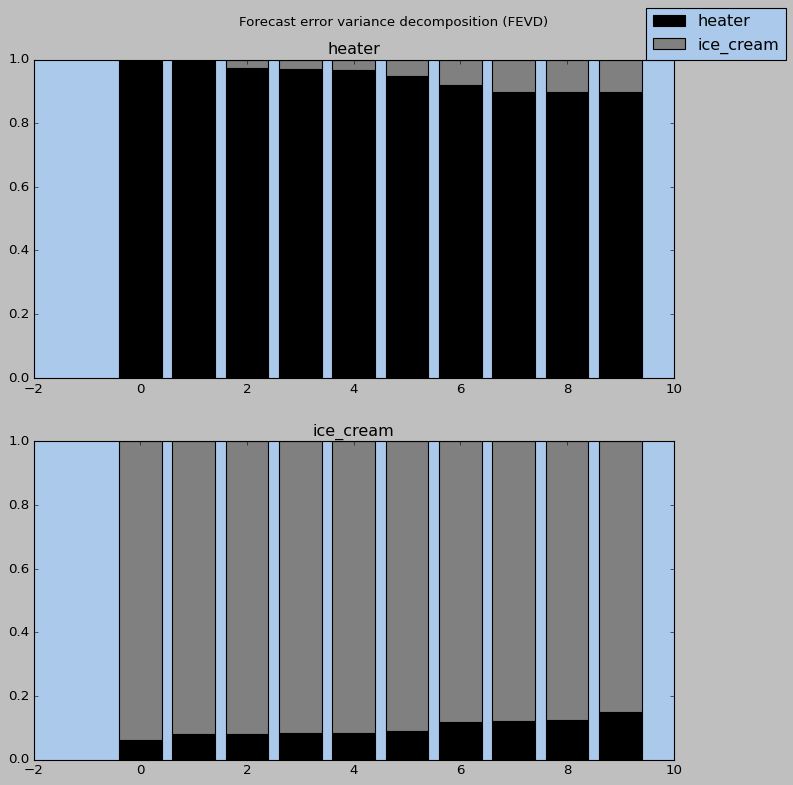

In [38]:
var_decomp.plot();

# Pruebas estadísticas

Se proporcionan varios métodos diferentes para llevar a cabo pruebas de hipótesis sobre los resultados del modelo y también la validez de los supuestos del modelo (normalidad, blancura/"iid-ness" de los errores, etc.).

- ## Causalidad de Granger

A menudo nos interesa saber si una variable o grupo de variables es “causal” para otra variable, para alguna definición de “causal”. En el contexto de los modelos VAR, se puede decir que un conjunto de variables son causales de Granger dentro de una de las ecuaciones VAR. No detallaremos las matemáticas ni la definición de la causalidad de Granger, pero se lo dejaremos al lector. El objeto `VARResults` tiene el método `test_causality` para realizar una prueba Wald ($\chi^2$) o una prueba F.

In [39]:
print(results.test_causality('heater', 'ice_cream', kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: ice_cream does not Granger-cause heater: reject at 5% significance level. Test statistic: 2.834, critical value: 1.788>, p-value: 0.001>


Accedamos a cada uno de los atributos

In [40]:
causa = results.test_causality('heater', 'ice_cream', kind='f')
# Obtener la prueba de hipótesis (H_0) y la decisión
hypothesis = causa.h0
decision = causa.conclusion

# Obtener el estadístico de prueba, el valor crítico y el valor p
test_statistic = causa.test_statistic
critical_value = causa.crit_value
p_value = causa.pvalue

# Imprimir los resultados
print("H_0:", hypothesis)
print("Decision:", decision)
print("Test statistic:", test_statistic)
print("Critical value [5%]:", critical_value)
print("p-value:", p_value)

H_0: H_0: ice_cream does not Granger-cause heater
Decision: reject
Test statistic: 2.8339896318933917
Critical value [5%]: 1.7878822356090727
p-value: 0.0011074317583597178


In [41]:
causa.summary()

Test statistic,Critical value,p-value,df
2.834,1.788,0.001,"(12, 272)"


- ## Normalidad

Como se señaló al principio de este documento, se supone que el componente de ruido blanco está distribuido normalmente. Si bien esta suposición no es necesaria para que las estimaciones de los parámetros sean consistentes o asintóticamente normales, los resultados generalmente son más confiables en muestras finitas cuando los residuos son ruido blanco gaussiano. Para probar si esta suposición es consistente con un conjunto de datos, VARResults ofrece el método `test_normality`.

In [42]:
print(results.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 358.555, critical value: 9.488>, p-value: 0.000>


In [43]:
normalidad = results.test_normality()
# Obtener la prueba de hipótesis (H_0) y la decisión
hypothesis = normalidad.h0
decision = normalidad.conclusion

# Obtener el estadístico de prueba, el valor crítico y el valor p
test_statistic = normalidad.test_statistic
critical_value = normalidad.crit_value
p_value = normalidad.pvalue

# Imprimir los resultados
print("H_0:", hypothesis)
print("Decision:", decision)
print("Test statistic:", test_statistic)
print("Critical value [5%]:", critical_value)
print("p-value:", p_value)

H_0: H_0: data generated by normally-distributed process
Decision: reject
Test statistic: 358.5550040843071
Critical value [5%]: 9.487729036781154
p-value: 2.4929390782791124e-76


In [44]:
normalidad.summary()

Test statistic,Critical value,p-value,df
358.6,9.488,0.000,4


- ## Verifique la correlación serial de los residuos

- La prueba de Durbin-Watson es una prueba de autocorrelación en los residuos de un análisis de regresión estadística.
- El estadístico de Durbin-Watson siempre tendrá un valor entre 0 y 4.
- Un valor de 2,0 significa que no se detecta autocorrelación en la muestra.
- Los valores de 0 a menos de 2 indican autocorrelación positiva y los valores de más de 2 a 4 indican autocorrelación negativa.
- Algunas personas también utilizan un valor de 1 para indicar autocorrelación positiva y un valor de 3 para indicar autocorrelación negativa.
- Cuanto más cerca de 0 esté la estadística, más evidencia de una correlación serial positiva. Cuanto más cerca de 4, más evidencia de correlación serial negativa.
- Las pruebas se aplican a los residuos de un análisis de regresión en el orden en que aparecen los regresores en el modelo.

In [45]:
# Perform the test now
sm.stats.durbin_watson(results.resid)

array([1.92862505, 1.99877804])

Como podemos ver en la matriz de resultados, el estadístico de Durbin Watson para cada variable es cercano a 2, lo que indica que no hay autocorrelación entre los residuos (bueno para nosotros).

## Evaluamos el Modelo

In [46]:
from sklearn import metrics

In [47]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    return 

In [48]:
timeseries_evaluation_metrics_func(prueba["heater"],prueba["heater_forecast"])

MSE is : 17.510582039776693
MAE is : 3.376910924114249
RMSE is : 4.1845647371951
MAPE is : 10.84774646019942
R2 is : 0.8621948702038313



In [49]:
timeseries_evaluation_metrics_func(prueba["ice_cream"],prueba["ice_cream_forecast"])

MSE is : 93.56841599327011
MAE is : 7.189419798869572
RMSE is : 9.673076862781052
MAPE is : 12.213902771532055
R2 is : 0.7151270006917687



## 8. Conclusiones

* El modelo VAR utiliza la correlación multivariante para hacer un modelo para múltiples variables objetivo.
* El orden del modelo VAR, p, determina el número de pasos hacia atrás que se utilizan para predecir el futuro.
* La implementación del modelo VAR puede definir el número ideal de retrasos utilizando el parámetro maxlags y el criterio de información de Akaike.
* El modelo VAR necesita estimar una gran cantidad de parámetros, lo que hace que requiera una gran cantidad de datos históricos. Esto hace que sea difícil estimar retrasos mayores.